In [1]:
import scipy.linalg as la
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
from main_grape.Grape import Grape
%pylab inline

from IPython import display


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#Defining time scales
total_time = 8.0
steps = 400

state_transfer = False

#Defining H0
qubit_state_num = 4
alpha = 0.224574
freq_ge = 3.9225#GHz
ens = np.array([ 2*np.pi*ii*(freq_ge - 0.5*(ii-1)*alpha) for ii in np.arange(qubit_state_num)])
Q_x   = np.diag(np.sqrt(np.arange(1,qubit_state_num)),1)+np.diag(np.sqrt(np.arange(1,qubit_state_num)),-1)
Q_z   = np.diag(np.arange(0,qubit_state_num))
I_q = np.identity(qubit_state_num)
H_q = np.diag(ens)
H0 = H_q 
       

#Defining Concerned states (starting states)
if state_transfer:
    psi0=[0]
else:
    psi0 = [0,1]

#Defining states to include in the drawing of occupation
states_draw_list = [0,1,2]
states_draw_names = ['g','e','f']

#Defining U (Target)
if state_transfer:
    U = np.zeros(qubit_state_num,dtype=complex)
    U[1]=(0+1j)/np.sqrt(2)
    U[0]=1/np.sqrt(2)
    
else:
    Ut_c = la.expm((0-1j)*total_time*H0)
    Ct_c = Ut_c.copy()
    Ct_c[1,0] = 1
    Ct_c[0,1] = 1
    Ct_c[0,0] = 0
    Ct_c[1,1] = 0
    U = Ct_c

#Defining U0 (Initial)
q_identity = np.identity(qubit_state_num)
U0= q_identity

#Defining control Hs
XI = Q_x
ZI = Q_z
Hops = [XI,ZI]
ops_max_amp = [2.0,2.0]
Hnames =['x','z']

#Defining convergence parameters
max_iterations = 250
decay = max_iterations/2
convergence = {'rate':0.01, 'update_step':10, 'max_iterations':max_iterations,\
               'conv_target':1e-6,'learning_rate_decay':decay}

#Definining reg coeffs
states_forbidden_list = [3]
reg_coeffs = {'envelope' : 0.01, 'dc':0.01, 'dc_id':[1],'dc_seg_num':1, 'dwdt':0.001,'d2wdt2':0.001*0.0001, 'forbidden':100,
             'states_forbidden_list':states_forbidden_list}



L-BFGS-B optimization done


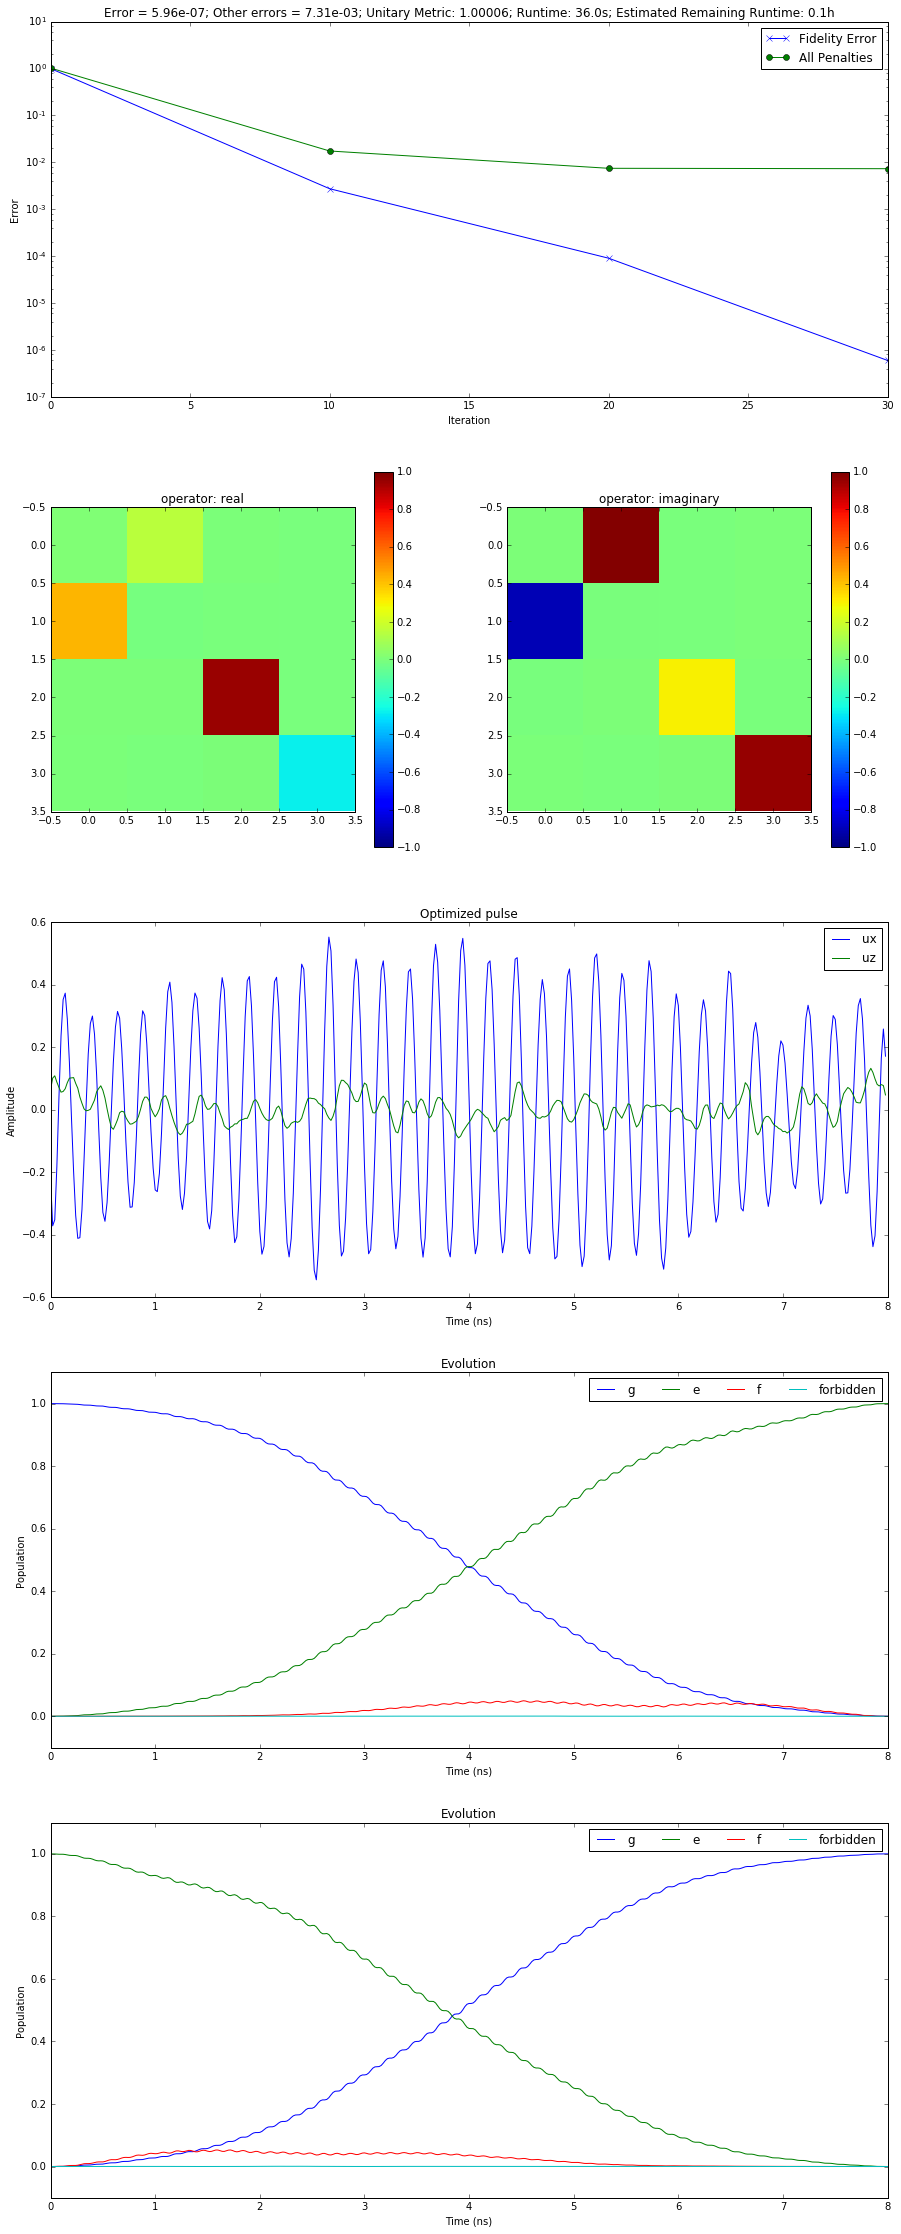

In [3]:
uks,U_final = Grape(H0,Hops,Hnames,U,total_time,steps,psi0,convergence=convergence, draw = [states_draw_list,states_draw_names],show_plots = True, 
 unitary_error = 1e-8, method = 'L-BFGS-B',switch = False,  maxA=ops_max_amp,\
                    reg_coeffs=reg_coeffs, file_name='transmon_pi', data_path = '/home/nelson/Simulations/GRAPE-Data/transmon_pi')
      

In [1]:
import numpy as np
import h5py

with h5py.File('/home/nelson/Simulations/GRAPE-Data/transmon_pi/00007_transmon_pi.h5','r') as hf:
    print('List of arrays in this file: \n', hf.keys())
    steps = np.array(hf.get('steps'))
    print steps
    total_time = np.array(hf.get('total_time'))
    print total_time
    print np.array(hf.get('states_concerned_list'))
    print np.array(hf.get('iteration'))
    print np.array(hf.get('error'))
    print len(np.array(hf.get('iteration')))
    print len(np.array(hf.get('error')))
    #plt.plot(log10(hf.get('error')))
    print np.array(hf.get('inter_vecs_mag_squared')).shape
    

('List of arrays in this file: \n', [u'H0', u'Hnames', u'Hops', u'U', u'convergence', u'error', u'final_state', u'inter_vecs_mag_squared', u'iteration', u'reg_error', u'states_concerned_list', u'steps', u'total_time', u'uks'])
400
8.0
[0 1]
[ 0 10 20 30 40 50 60]
[  9.97573018e-01   1.35072470e-02   2.01463699e-04   6.02602959e-05
   2.70605087e-05   1.63912773e-05   1.52587891e-05]
7
7
(7, 2, 4, 401)
